# Acceptance matching cut in 2D

last edit Apr-1, 2023

## Imports and definitions

In [1]:
import sys; 
software_path = '/Users/erezcohen/Desktop/Software/'
sys.path.insert(0, software_path + '/mySoftware/Python/');
sys.path.insert(0, software_path + '/CLAS12/BAND/SIDIS_at_BAND/PythonAnalysis/AcceptanceCorrections/');
sys.path.insert(0, software_path + '/CLAS12/BAND/SIDIS_at_BAND/PythonAnalysis/python_auxiliary/');
from my_tools                     import *; 
from plot_tools                   import *;
from my_data_analysis_tools       import *;
from acceptance_correction_tools  import *;
from sidis_analysis_tools         import *;

In [2]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams['mathtext.fontset']    = 'stix'
plt.rcParams['font.family']         = 'STIXGeneral'

In [3]:
figures_path = "/Users/erezcohen/Desktop/Projects/BAND/AnalysisNote/Figures/EventSelection/"
import ROOT 

Welcome to JupyROOT 6.26/06


In [4]:
pd.options.display.precision = 1

# Auxiliary

In [5]:
def compute_cut_impact_on_statistics(df_pips, df_pims, Npips_noCuts=1,Npims_noCuts=1):
    # Npips,Npims,fpips,dfpips,fpims,dfpims  = compute_cut_impact_on_statistics(Events,Npips_noCuts=1,Npims_noCuts=1)
    Npips,Npims = len(df_pips),len(df_pims)
    
    fpips  = 100.*Npips/Npips_noCuts
    dfpips = fpips * np.sqrt(1./np.max([Npips,1])+1./Npips_noCuts)
    fpims  = 100.*Npims/Npims_noCuts
    dfpims = fpims * np.sqrt(1./np.max([Npims,1])+1./Npims_noCuts)

    return Npips,Npims,fpips,dfpips,fpims,dfpims 

# (1) Load data and cut values

## (1.1) Load cut variables

In [6]:
cuts = pd.read_csv( '/Users/erezcohen/Desktop/Software/CLAS12/BAND/SIDIS_at_BAND/macros/cuts/BANDcutValues.csv' );

## (1.2) Load data

In [7]:
data_path = '/Users/erezcohen/Desktop/data/BAND/inclusive_no_cuts/Mar24_2023/';

In [8]:
NeventsMax        = 1e6
Nruns             = 3;
Nevntries_per_run = 'all';
rgb_runs_filename = "good_runs_10-2-final.txt"
rgb_runs = read_run_nunmbers( runs_filename=rgb_runs_filename, Nruns=Nruns )

In [9]:
rgb_runs = np.array([6422,6426,6429])

In [10]:

e_Sector, pi_Sector = dict(),dict()
Ve_z,     Vpi_z     = dict(),dict()
W,Q2,y              = dict(),dict(),dict()
e_P,pi_P,e_Theta    = dict(),dict(),dict()
pi_Theta,e_Phi      = dict(),dict()
pi_Phi              = dict()
e_E_PCAL, e_E_ECIN  = dict(),dict()
e_E_ECOUT, e_PCAL_W = dict(),dict()
e_PCAL_V            = dict()
pi_chi2PID          = dict()
Zpi                 = dict()
Npions              = dict()
Npips, Npims        = dict(), dict()
e_DC_x,e_DC_y       = dict(), dict()
pi_DC_x,pi_DC_y     = dict(), dict()
omega               = dict() 
Mx                  = dict()

Ve = ROOT.TVector3()
Vpi = ROOT.TVector3()
e  = ROOT.TLorentzVector()
pi = ROOT.TLorentzVector()
q  = ROOT.TLorentzVector()
p_rest = ROOT.TLorentzVector(); p_rest.SetXYZM(0, 0, 0, 0.938272);

Nevts = dict()
for pi_ch,pi_idx in zip(pi_charge_names,[1,2]):
    W[pi_ch],Q2[pi_ch],y[pi_ch]      = [],[],[]
    e_P[pi_ch],     pi_P[pi_ch]      = [],[]
    e_Theta[pi_ch], pi_Theta[pi_ch]  = [],[]  
    e_Phi[pi_ch],   pi_Phi[pi_ch]    = [],[]
    e_Sector[pi_ch],pi_Sector[pi_ch] = [],[]    
    Ve_z[pi_ch],    Vpi_z[pi_ch]     = [],[]
    e_E_PCAL[pi_ch], e_E_ECIN[pi_ch] = [],[]
    e_E_ECOUT[pi_ch], e_PCAL_W[pi_ch]= [],[]
    e_PCAL_V[pi_ch]                  = []  
    Zpi[pi_ch]                       = []
    pi_chi2PID[pi_ch]                = []
    Npips[pi_ch], Npims[pi_ch]       = [], []
    Nevts[pi_ch]                     = 0
    
    e_DC_x[pi_ch]                    = []
    e_DC_y[pi_ch]                    = []
    pi_DC_x[pi_ch]                   = []
    pi_DC_y[pi_ch]                   = []
    omega[pi_ch]                     = []
    Mx[pi_ch]                        = []
    
for runnum,runIdx in zip(rgb_runs,range(Nruns)):#{

    for pi_ch,pi_idx in zip(pi_charge_names,[1,2]):
        filename = data_path + 'skimmed_SIDIS_sidisdvcs_00%d_e_%s.root'%(runnum,pi_ch)
        f = ROOT.TFile(filename)
        tree = f.Get("tree")

        for entryNum in range(0,tree.GetEntries()):
            # print(pi_ch,runnum,entryNum)
            if ((Nevntries_per_run!='all') and (entryNum >= Nevntries_per_run) or (Nevts[pi_ch] >= NeventsMax)): break;
            
            tree.GetEntry(entryNum)
            Npi = getattr(tree,"Npi")
            Npips[pi_ch] = getattr(tree,"Npips")
            Npims[pi_ch] = getattr(tree,"Npims")

            if pi_ch=='piplus'  and Npips[pi_ch]==0: continue
            if pi_ch=='piminus' and Npims[pi_ch]==0: continue

            e_E_PCAL[pi_ch] .append( getattr(tree,"e_E_PCAL") ) 
            e_E_ECIN[pi_ch] .append( getattr(tree,"e_E_ECIN") )
            e_E_ECOUT[pi_ch].append( getattr(tree,"e_E_ECOUT"))
            e_PCAL_W[pi_ch] .append( getattr(tree,"e_PCAL_W") )
            e_PCAL_V[pi_ch] .append( getattr(tree,"e_PCAL_V") )
            e_Sector[pi_ch] .append( getattr(tree,"e_DC_sector") )

            e_DC_x_arr      = getattr(tree,"e_DC_x")
            e_DC_y_arr      = getattr(tree,"e_DC_y")

            # Three layers for the electron DC 
            e_DC_x[pi_ch].append([e_DC_x_arr[0],e_DC_x_arr[1],e_DC_x_arr[2]])
            e_DC_y[pi_ch].append([e_DC_y_arr[0],e_DC_y_arr[1],e_DC_y_arr[2]])


            e  = getattr(tree,"e") 
            Ve =  getattr(tree,"Ve") 
            Ve_z[pi_ch]    .append(Ve.Z()) 
            e_P[pi_ch]     .append(e.P()) 
            e_Theta[pi_ch] .append(e.Theta()) 
            e_Phi[pi_ch]   .append(e.Phi()) 
            y[pi_ch]       .append(getattr(tree,"y"))
            W[pi_ch]       .append(getattr(tree,"W"))
            Q2[pi_ch]      .append(getattr(tree,"Q2"))
            omega[pi_ch]   .append(getattr(tree,"omega"))


            q               = getattr(tree,"q") 
            pi              = getattr(tree,"pi") 
            Vpi             = getattr(tree,"Vpi") 
            pi_DC_sector    = getattr(tree,"pi_DC_sector")
            pi_chi2PID_arr  = getattr(tree,"pi_chi2PID")
            pi_DC_x_arr     = getattr(tree,"pi_DC_x")
            pi_DC_y_arr     = getattr(tree,"pi_DC_y")


            Zpi[pi_ch]      .append( getattr(tree,"Z") )
            pi_P[pi_ch]     .append(pi[0].P()) 
            pi_Theta[pi_ch] .append(pi[0].Theta()) 
            pi_Phi[pi_ch]   .append(pi[0].Phi()) 
            pi_Sector[pi_ch].append(pi_DC_sector[0]) 
            # Three layers for the pion DC 
            pi_DC_x[pi_ch].append([pi_DC_x_arr[0],pi_DC_x_arr[1],pi_DC_x_arr[2]])
            pi_DC_y[pi_ch].append([pi_DC_y_arr[0],pi_DC_y_arr[1],pi_DC_y_arr[2]])


            Vpi_z[pi_ch]    .append(Vpi[0].Z()) 
            pi_chi2PID[pi_ch].append(pi_chi2PID_arr[0] )
            Mx[pi_ch]       .append(( q + p_rest - pi[0] ).Mag());
            Nevts[pi_ch] = Nevts[pi_ch]+1 
            #print('event',entryNum,', Npips:',getattr(tree,"Npips"),', pi_chi2PID:',pi_chi2PID_arr[0])
            # print('Nevts[',pi_ch,']:',Nevts[pi_ch]);
        #}
        f.Close()
        # print("Collected %d "%entryNum+" events from run %d."%runnum)
    #}
#}
print('Done.')
for pi_ch,pi_idx in zip(pi_charge_names,[1,2]): print("Collected %d d(e,e'"%Nevts[pi_ch]+pi_ch+") events in total.")

Done.
Collected 1000000 d(e,e'piplus) events in total.
Collected 1000000 d(e,e'piminus) events in total.


In [11]:
Events = dict()
for pi_ch in pi_charge_names:
    Events[pi_ch] = pd.DataFrame({'e_E_PCAL' :e_E_PCAL[pi_ch],
                                  'e_E_ECIN' :e_E_ECIN[pi_ch],                                
                                  'e_E_ECOUT':e_E_ECOUT[pi_ch],
                                  'e_PCAL_W' :e_PCAL_W[pi_ch],
                                  'e_PCAL_V' :e_PCAL_V[pi_ch],
                                  
                                  'Ve_z'     :Ve_z[pi_ch],
                                  'e_P'      :e_P[pi_ch],
                                  'e_Theta'  :e_Theta[pi_ch],
                                  'e_Phi'    :e_Phi[pi_ch],
                                  'e_Sector' :e_Sector[pi_ch],
                                  'e_DC_x_l0'   :np.array(e_DC_x[pi_ch])[:,0],
                                  'e_DC_x_l1'   :np.array(e_DC_x[pi_ch])[:,2],
                                  'e_DC_x_l2'   :np.array(e_DC_x[pi_ch])[:,1],

                                  'e_DC_y_l0'   :np.array(e_DC_y[pi_ch])[:,0],
                                  'e_DC_y_l1'   :np.array(e_DC_y[pi_ch])[:,2],
                                  'e_DC_y_l2'   :np.array(e_DC_y[pi_ch])[:,1],

                                  'y'        :y[pi_ch],
                                  'W'        :W[pi_ch],
                                  'Q2'       :Q2[pi_ch],
                                  'omega'    :omega[pi_ch],
                                  'Mx'       :Mx[pi_ch],



                                  'Vpi_z'    :Vpi_z[pi_ch],
                                  'pi_P'     :pi_P[pi_ch],
                                  'pi_Theta' :pi_Theta[pi_ch],
                                  'pi_Phi'   :pi_Phi[pi_ch],
                                  'pi_Sector':pi_Sector[pi_ch],   
                                  'pi_DC_x_l0'   :np.array(pi_DC_x[pi_ch])[:,0],
                                  'pi_DC_x_l1'   :np.array(pi_DC_x[pi_ch])[:,2],
                                  'pi_DC_x_l2'   :np.array(pi_DC_x[pi_ch])[:,1],

                                  'pi_DC_y_l0'   :np.array(pi_DC_y[pi_ch])[:,0],
                                  'pi_DC_y_l1'   :np.array(pi_DC_y[pi_ch])[:,2],
                                  'pi_DC_y_l2'   :np.array(pi_DC_y[pi_ch])[:,1],

                                  'Zpi'      :Zpi[pi_ch],
                                  'pi_chi2PID':pi_chi2PID[pi_ch],
                                  'Npips'    :Npips[pi_ch],
                                  'Npims'    :Npims[pi_ch],
                                 })
print('Created dataFrames')


Created dataFrames


## (1.3) Create a data-frame to count the statistics per cut
#### !!!ToDo: Add the first requirement: $(e,e'\pi)$ event where the pion is detected by the forward detector!!!!

In [12]:
cols=['Cut','$N_{\pi^+}$','$N_{\pi^-}$',
                              '$f_{\pi^+}$ [%]','$\Delta f_{\pi^+}$ [%]',
                              '$f_{\pi^-}$ [%]','$\Delta f_{\pi^-}$ [%]']
Nevents = pd.DataFrame(columns=cols)

In [13]:
Npips,Npims,fpips,dfpips,fpims,dfpims  = compute_cut_impact_on_statistics(Events['piplus'],Events['piminus'], Npips_noCuts=len(Events['piplus']),Npims_noCuts=len(Events['piminus']))
Npips_noCuts,Npims_noCuts = Npips, Npims
Nevents = pd.concat([Nevents,pd.DataFrame({cols[0]:'No cut',cols[1]:Npips,cols[2]:Npims,cols[3]:fpips,cols[4]:dfpips,cols[5]:fpims,cols[6]:dfpims},index=[0])])
Nevents

,Cut,$N_{\pi^+}$,$N_{\pi^-}$,$f_{\pi^+}$ [%],$\Delta f_{\pi^+}$ [%],$f_{\pi^-}$ [%],$\Delta f_{\pi^-}$ [%]
0,No cut,1000000,1000000,100.0,0.1,100.0,0.1


# (2) Reproduce Alex' acceptance matching cut in 2D

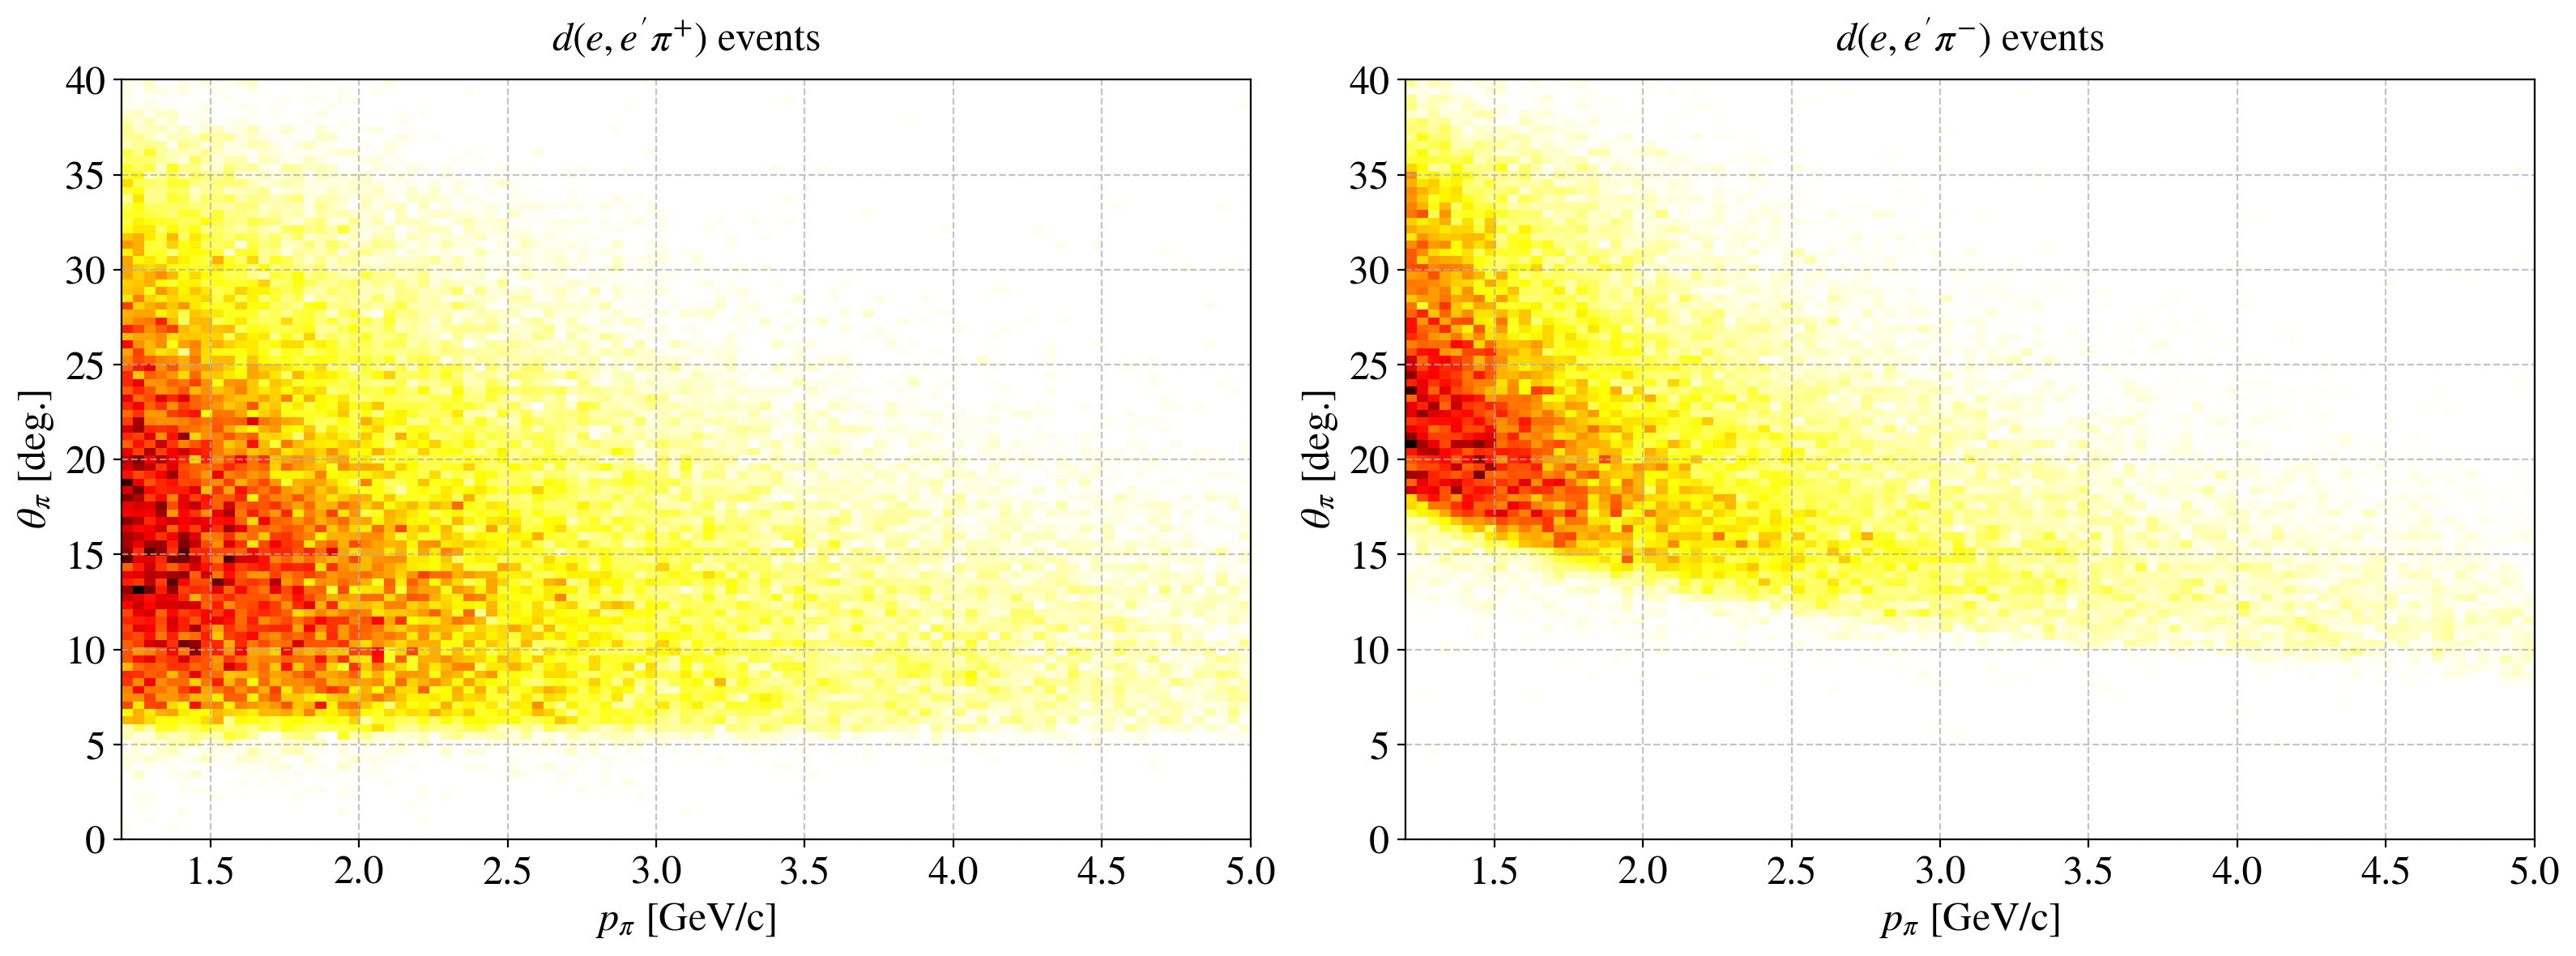

In [61]:
# theta_Pi vs. p_Pi
fig = plt.figure(figsize=(16,6),tight_layout=True)
bins = (np.linspace(1.2,5,100),np.linspace(0,40,100))
sector = 1

for pi_ch,pi_label,pi_idx in zip(pi_charge_names,pi_labels,[1,2]):
    p = np.array(pi_P[pi_ch])
    theta = np.array(pi_Theta[pi_ch])*180./np.pi
    pi_sector = np.array(pi_Sector[pi_ch])
    
    ax = fig.add_subplot(1,2,pi_idx)
    plt.hist2d( p[pi_sector==sector], theta[pi_sector==sector], bins , cmap='hot_r')

    
    
    # plt.hist( x, bins=np.linspace(xmin,xmax,Nbins),density=True,edgecolor='k');
    set_axes(ax,'$p_\pi$ [GeV/c]','$\\theta_\pi$ [deg.]',
             title="$d(e,e'"+pi_label+")$ events",
             fontsize=18,do_add_grid=True)

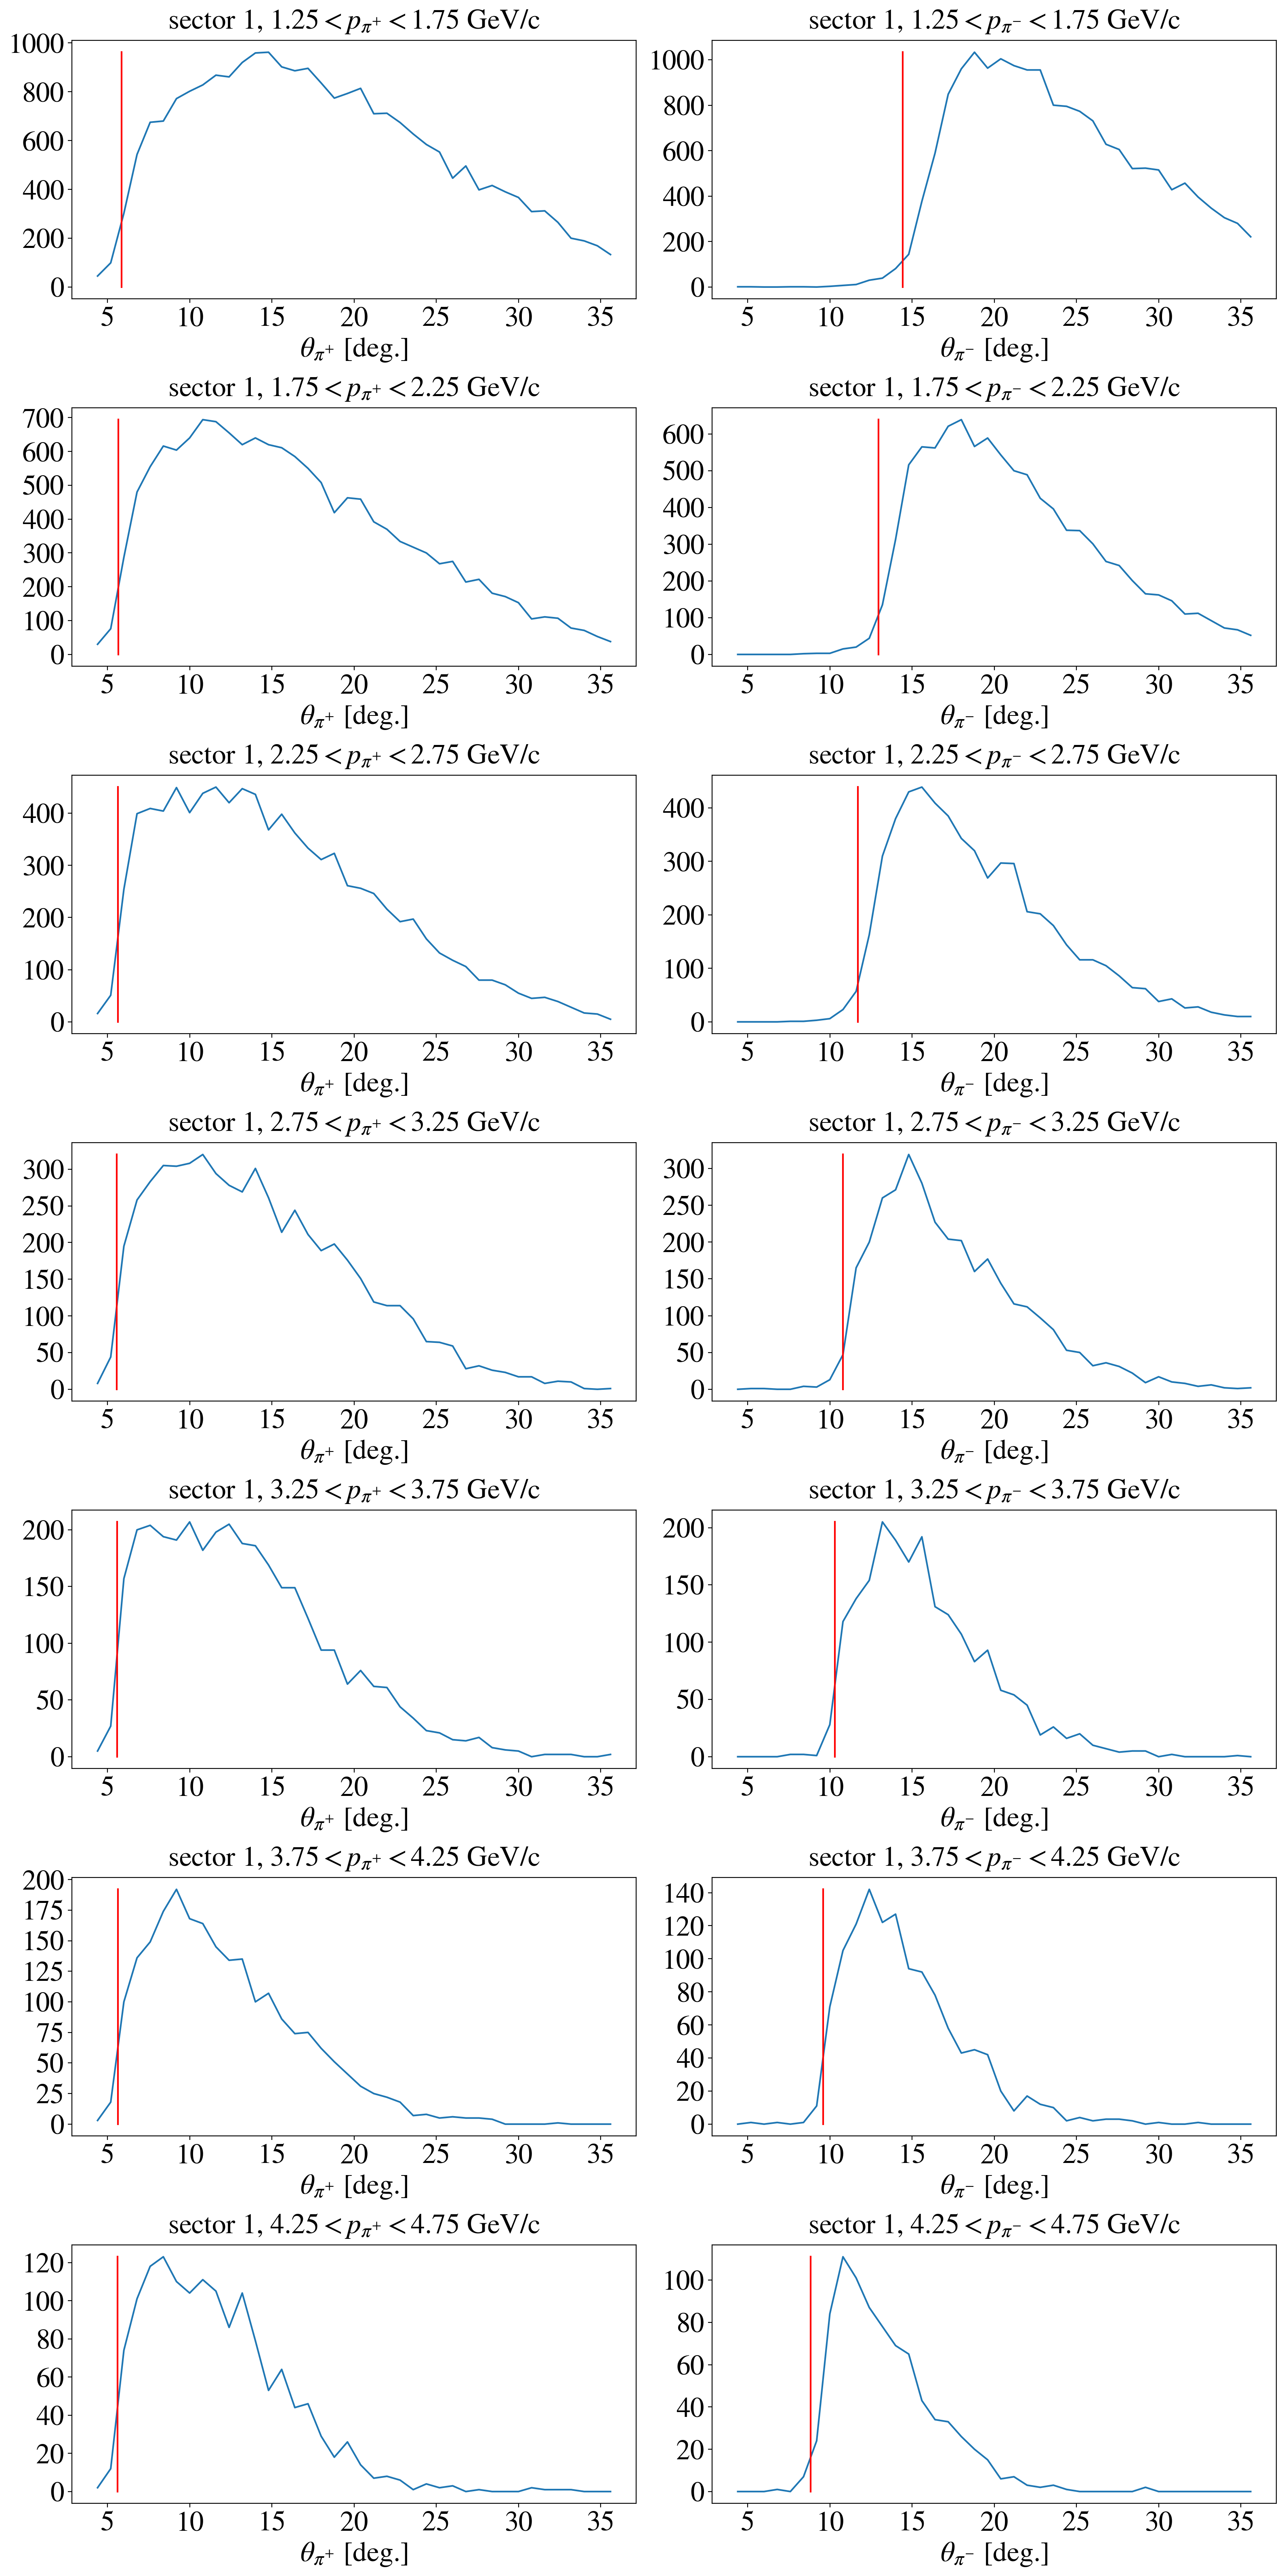

In [62]:
fig = plt.figure(figsize=(16,32),tight_layout=True)
delta_p   = 0.5
p_min_arr = np.arange(1.25,5,delta_p)
p_max_arr = p_min_arr + delta_p

theta_bins = np.linspace(4,36,41)
sector = 1
Np = 7

for pi_ch,pi_label,pi_idx in zip(pi_charge_names,pi_labels,[1,2]):
    p = np.array(pi_P[pi_ch])
    theta = np.array(pi_Theta[pi_ch])*180./np.pi
    pi_sector = np.array(pi_Sector[pi_ch])


    for p_min,p_max,p_idx in zip(p_min_arr,p_max_arr,range(Np)):
        theta_in_bin = theta[ (pi_sector==sector) & (p_min < p) & (p < p_max) ]
        ax = fig.add_subplot( Np, 2, 2*p_idx + pi_idx )
        h,edges = np.histogram( theta_in_bin, theta_bins )
        # h,edges,_ = ax.hist(theta_in_bin, theta_bins, histtype='step')
        x = (edges[1:]+edges[:-1])/2
        plt.plot(x, h)
        set_axes(ax,'$\\theta_{%s}$ [deg.]'%pi_label,'',
                 title="sector %d, $%.2f < p_{%s} < %.2f$ GeV/c"%(sector,p_min,pi_label,p_max))
        
        # find the theta value for X% of the distribution
        theta_prctl = np.percentile( theta_in_bin, 1 )
        plt.plot([theta_prctl,theta_prctl],[0,np.max(h)],'-r')
        if p_idx>=Np: break

